In [16]:
from collections import defaultdict
import sys
from typing import Dict, Optional
sys.path.append('../')

from hl_gauss_pytorch import HLGaussLoss, HLGaussLayer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import torch
from torch import nn
from torch.nn import functional as F
from tqdm import tqdm

from idbd import IDBD
from adam import Adam

%matplotlib inline

In [23]:
class EnsembleIDBD(IDBD):
    """A version of IDBD that treats each feature as an individual predictor."""
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        assert self.version == 'squared_inputs', "Only squared_inputs works for EnsembleIDBD"
            
    @torch.no_grad()
    def step(
        self,
        losses: torch.Tensor,
        predictions: torch.Tensor,
        param_inputs: Dict[torch.nn.parameter.Parameter, torch.Tensor],
        closure: Optional[callable] = None,
    ) -> Optional[float]:
        """Performs a single optimization step.
        
        Args:
            loss: Loss tensor of shape ()
            predictions: Predictions tensor of shape (batch_size, n_classes)
            param_inputs: Dictionary mapping linear layer weight parameters to their inputs
        """
        assert losses.shape == predictions.shape
        
        with torch.enable_grad():
            loss = losses.sum()
            loss.backward()

        param_updates = []
        for group in self.param_groups:
            meta_lr = group['meta_lr']
            tau = group['tau']
            
            for p in group['params']:
                if p.grad is None:
                    continue
                
                grad = p.grad
                
                if p in param_inputs:
                    assert len(param_inputs[p].shape) == 1, "Inputs must be 1D tensors"
                    inputs = param_inputs[p].unsqueeze(0)
                elif len(grad.shape) == 1:
                    inputs = torch.ones_like(grad)
                else:
                    raise ValueError(f"Parameter {p} not found in activations dictionary.")
                
                # Get state variables
                state = self.state[p]
                beta = state['beta']
                h = state['h']
                if self.autostep:
                    v = state['v']
                
                ### Update state variables ###
                
                squared_inputs = inputs.pow(2)
                
                # Calculate and update step-size (learning rate / alpha)
                if self.autostep:
                    alpha = torch.exp(state['beta'])
                    v = torch.max(
                        torch.abs(grad * h),
                        v + 1.0 / tau * alpha * squared_inputs * (torch.abs(grad * h) - v),
                    )
                    new_alpha = alpha * torch.exp(meta_lr * grad * h / v)
                    alpha = torch.where(
                        v != 0,
                        new_alpha,
                        alpha,
                    )
                    
                    # Normalize the step-size
                    effective_step_size = torch.clamp(alpha * squared_inputs, min=1.0)
                    alpha /= effective_step_size
                    state['beta'] = torch.log(alpha)
                else:
                    beta.add_(meta_lr * grad * h)
                    state['beta'] = beta
                    alpha = torch.exp(beta)
                
                # Queue paramter update
                weight_decay_term = self.weight_decay * p.data if self.weight_decay != 0 else 0
                param_update = -alpha * (grad + weight_decay_term)
                param_updates.append((p, param_update))
                
                # Update h (gradient trace)
                state['h'] = h * (1 - alpha * squared_inputs).clamp(min=0) + alpha * grad
                
        for p, param_update in param_updates:
            p.add_(param_update)

        return loss

In [4]:
def train_linear_model(
    n_inputs, 
    noise_strength,
    max_steps = 400000,
    target_rtol = 0.05,
    target_atol = 0.00001,
    meta_lr = 0.01,
    init_lr = 0.01,
    seed = 0,
):
    """Run an experiment with a normal linear model."""
    torch.manual_seed(seed)
    
    ### Prepare model and optimizer ###
    
    true_weights = torch.randn(1, n_inputs)
    model = torch.nn.Linear(n_inputs, 1, bias=False)
    torch.nn.init.zeros_(model.weight)

    optimizer = IDBD(model.parameters(), meta_lr=meta_lr, init_lr=init_lr, autostep=True)

    ### Create inputs and targets ###

    true_inputs = torch.randint(0, 2, (max_steps, n_inputs,), dtype=torch.float)
    noisy_inputs = true_inputs + torch.randn(max_steps, n_inputs) * noise_strength
    targets = true_inputs @ true_weights.T

    losses = []
    time_to_val = torch.inf * torch.ones(n_inputs, dtype=torch.float)
    
    for i, (input_val, target_val) in enumerate(zip(noisy_inputs, targets)):
        
        ### Train the model on a sample ###
        
        y_pred = model(input_val)
        loss = 0.5 * torch.nn.functional.mse_loss(y_pred, target_val)
        losses.append(loss.item())

        param_inputs = {model.weight: input_val}
        optimizer.zero_grad()
        optimizer.step(loss, y_pred, param_inputs)
        
        ### Check which weights have reached their ideal value ###
        
        with torch.no_grad():
            # Find the weights that are close
            model_weights = model.weight.data[0]
            weights_close = torch.isclose(true_weights[0], model_weights, rtol=target_rtol, atol=target_atol)
            new_time_to_val = torch.minimum(torch.full_like(time_to_val, i), time_to_val)
            time_to_val = torch.where(weights_close, new_time_to_val, time_to_val) # torch.inf)
            
            not_close_rtol = target_rtol * 2
            weights_not_close = ~torch.isclose(true_weights[0], model_weights, rtol=not_close_rtol, atol=target_atol)
            time_to_val = torch.where(weights_not_close, torch.inf, time_to_val)
        
            if not torch.isinf(time_to_val).any():
                break
    
    return {
        'loss': losses,
        'time_to_val': time_to_val,
    }

tensor(1166.)


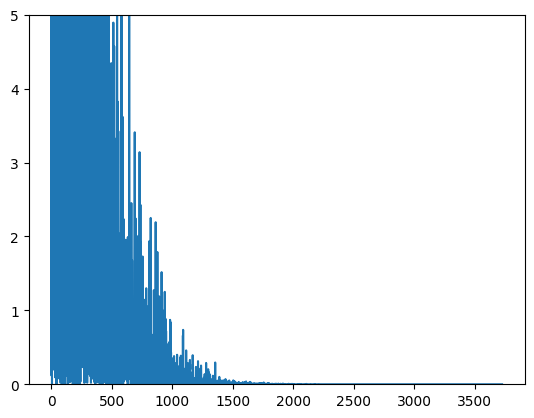

In [130]:
results = train_linear_model(100, 0.0, target_rtol=0.05, target_atol=0.0001, init_lr=0.01, max_steps=10000)
losses = results['loss']
time_to_val = results['time_to_val']
plt.plot(losses)
plt.ylim(0, 5)
print(time_to_val.median())

In [5]:
def train_dupe_feature_linear_model(
    n_inputs, 
    noise_strength,
    max_steps = 400000,
    target_rtol = 0.05,
    target_atol = 0.00001,
    meta_lr = 0.01,
    init_lr = 0.01,
    seed = 0,
):
    """Run an experiment with a linear model that has duplicate noisy and non-noisy features."""
    torch.manual_seed(seed)
    
    ### Prepare model and optimizer ###
    
    true_weights = torch.randn(1, n_inputs)
    model = torch.nn.Linear(n_inputs * 2, 1, bias=False)
    torch.nn.init.zeros_(model.weight)
    
    # Init noisy input weights as true values
    with torch.no_grad():
        model.weight.data[:, :n_inputs] = true_weights

    optimizer = IDBD(model.parameters(), meta_lr=meta_lr, init_lr=init_lr, autostep=True)

    ### Create inputs and targets ###

    true_inputs = torch.randint(0, 2, (max_steps, n_inputs,), dtype=torch.float)
    noisy_inputs = true_inputs + torch.randn(max_steps, n_inputs) * noise_strength
    full_inputs = torch.cat([noisy_inputs, true_inputs], dim=1)
    targets = true_inputs @ true_weights.T

    losses = []
    time_to_val = torch.inf * torch.ones(n_inputs, dtype=torch.float)
    time_to_pass = torch.inf * torch.ones(n_inputs, dtype=torch.float)
    
    for i, (input_val, target_val) in enumerate(zip(full_inputs, targets)):
        
        ### Train the model on a sample ###
        
        y_pred = model(input_val)
        loss = 0.5 * torch.nn.functional.mse_loss(y_pred, target_val)
        losses.append(loss.item())

        param_inputs = {model.weight: input_val}
        optimizer.zero_grad()
        optimizer.step(loss, y_pred, param_inputs)
        
        ### Check which weights have reached their ideal value ###
        
        with torch.no_grad():
            # Find the weights that are close
            new_weights = model.weight.data[0, n_inputs:]
            weights_close = torch.isclose(true_weights[0], new_weights, rtol=target_rtol, atol=target_atol)
            new_time_to_val = torch.minimum(torch.full_like(time_to_val, i), time_to_val)
            time_to_val = torch.where(weights_close, new_time_to_val, time_to_val) # torch.inf)
            
            not_close_rtol = target_rtol * 2
            weights_not_close = ~torch.isclose(true_weights[0], new_weights, rtol=not_close_rtol, atol=target_atol)
            time_to_val = torch.where(weights_not_close, torch.inf, time_to_val)
        
            if not torch.isinf(time_to_val).any():
                break
            
        ### Check which weights have surpassed their counterparts ###
        
        with torch.no_grad():
            orig_weights = model.weight.data[0, :n_inputs]
            new_weights = model.weight.data[0, n_inputs:]
            
            weight_surpassed = torch.abs(new_weights) > torch.abs(orig_weights)
            new_time_to_pass = torch.minimum(torch.full_like(time_to_pass, i), time_to_pass)
            time_to_pass = torch.where(weight_surpassed, new_time_to_pass, torch.inf)
    
    return {
        'loss': losses,
        'time_to_val': time_to_val,
        'time_to_pass': time_to_pass,
    }

tensor(5609.) tensor(1282.)


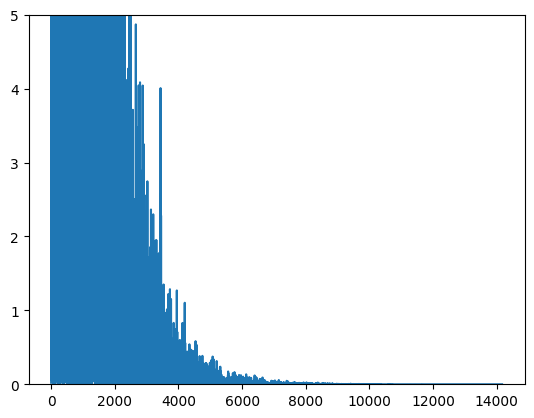

In [143]:
results = train_dupe_feature_linear_model(100, 0.5, target_rtol=0.05, target_atol=0.0001, init_lr=0.01, max_steps=30000)
plt.plot(results['loss'])
plt.ylim(0, 5)
print(results['time_to_val'].median(), results['time_to_pass'].median())

In [154]:
def train_individual_utilities_linear_model(
    n_inputs, 
    noise_strength,
    max_steps = 400000,
    target_rtol = 0.05,
    target_atol = 0.00001,
    meta_lr = 0.01,
    init_lr = 0.01,
    seed = 0,
):
    """Run an experiment with a normal linear model."""
    torch.manual_seed(seed)

    decay_rate = 0.99
    
    ### Prepare model and optimizer ###
    
    true_weights = torch.randn(1, n_inputs)
    model = torch.nn.Linear(n_inputs, 1, bias=False)
    torch.nn.init.zeros_(model.weight)
    
    utility_model = torch.nn.Linear(n_inputs, 1, bias=False)
    utility_bias = torch.nn.Parameter(torch.zeros(n_inputs, dtype=torch.float))
    torch.nn.init.zeros_(utility_model.weight)
    
    optimizer = IDBD(model.parameters(), meta_lr=meta_lr, init_lr=init_lr, autostep=True)
    # utility_optimizer = EnsembleIDBD(utility_model.parameters(), meta_lr=meta_lr, init_lr=init_lr, autostep=True)
    utility_optimizer = torch.optim.Adam(list(utility_model.parameters()) + [utility_bias], lr=init_lr)

    ### Create inputs and targets ###

    true_inputs = torch.randint(0, 2, (max_steps, n_inputs,), dtype=torch.float)
    noisy_inputs = true_inputs + torch.randn(max_steps, n_inputs) * noise_strength
    targets = true_inputs @ true_weights.T

    losses = []
    time_to_val = torch.inf * torch.ones(n_inputs, dtype=torch.float)
    target_mean = 0.0
    target_var = 0.0
    input_mean = 0.0
    input_var = 0.0
    
    for i, (input_val, target_val) in enumerate(zip(noisy_inputs, targets)):
        
        ### Train the model on a sample ###
        
        y_pred = model(input_val)
        loss = 0.5 * torch.nn.functional.mse_loss(y_pred, target_val)
        losses.append(loss.item())

        param_inputs = {model.weight: input_val}
        optimizer.zero_grad()
        optimizer.step(loss, y_pred, param_inputs)

        ### Standardize the inputs and targets ###

        bias_correction_term = 1.0 / (1.0 - decay_rate ** (i + 1))

        target_mean = target_mean * decay_rate + target_val * (1 - decay_rate)
        bias_correctted_target_mean = target_mean * bias_correction_term
        centered_target = target_val - bias_correctted_target_mean
        
        input_mean = input_mean * decay_rate + input_val * (1 - decay_rate)
        bias_correctted_input_mean = input_mean * bias_correction_term
        centered_input = input_val - bias_correctted_input_mean
        
        target_var = target_var * decay_rate + centered_target ** 2 * (1 - decay_rate)
        bias_correctted_target_var = target_var * bias_correction_term
        standardized_target = torch.where(
            bias_correctted_target_var > 0,
            centered_target / torch.sqrt(bias_correctted_target_var),
            torch.zeros_like(centered_target),
        )
        
        input_var = input_var * decay_rate + centered_input ** 2 * (1 - decay_rate)
        bias_correctted_input_var = input_var * bias_correction_term
        standardized_input = torch.where(
            bias_correctted_input_var > 0,
            centered_input / torch.sqrt(bias_correctted_input_var),
            torch.zeros_like(centered_input),
        )
        
        ### Train the utility model ###
        
        individual_preds = utility_model.weight.squeeze(dim=0) * input_val
        individual_preds += utility_bias
        utility_losses = (individual_preds - torch.full_like(individual_preds, centered_target.item())) ** 2
        utility_losses = utility_losses.squeeze(dim=0)
        utility_loss = utility_losses.sum()
        
        # param_inputs = {utility_model.weight: input_val}
        # utility_optimizer.zero_grad()
        # utility_optimizer.step(utility_losses, individual_preds, param_inputs)
        
        utility_optimizer.zero_grad()
        utility_loss.backward()
        utility_optimizer.step()
        
        ### Check which weights have reached their ideal value ###
        
        with torch.no_grad():
            # Find the weights that are close
            utility_weights = utility_model.weight.data[0]
            weights_close = torch.isclose(true_weights[0], utility_weights, rtol=target_rtol, atol=target_atol)
            new_time_to_val = torch.minimum(torch.full_like(time_to_val, i), time_to_val)
            time_to_val = torch.where(weights_close, new_time_to_val, time_to_val) # torch.inf)
            
            not_close_rtol = target_rtol * 2
            weights_not_close = ~torch.isclose(true_weights[0], utility_weights, rtol=not_close_rtol, atol=target_atol)
            time_to_val = torch.where(weights_not_close, torch.inf, time_to_val)
        
            if not torch.isinf(time_to_val).any():
                break
    
    return {
        'loss': losses,
        'time_to_val': time_to_val,
        'true_weights': true_weights,
        'model_weights': model.weight.data[0],
        'utility_weights': utility_model.weight.data[0],
    }

tensor(1528.)
tensor([[ 1.5410, -0.2934, -2.1788]])
tensor([ 1.5410, -0.2934, -2.1788])
tensor([ 1.4526, -0.2836, -2.2570])


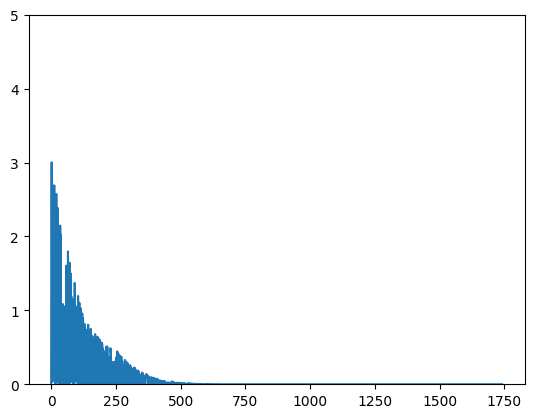

In [161]:
results = train_individual_utilities_linear_model(
    3, 0.0, target_rtol=0.05, target_atol=0.0001, init_lr=0.01, max_steps=6000)
losses = results['loss']
time_to_val = results['time_to_val']
plt.plot(losses)
plt.ylim(0, 5)
print(time_to_val.median())
print(results['true_weights'])
print(results['model_weights'])
print(results['utility_weights'])

In [131]:
time_to_val

tensor([1528., 1741., 1301.])

In [45]:
time_to_val

tensor([131518.,     inf,     inf,     inf, 182526.,     inf,     inf,  46826.,
            inf,  50369.,     inf,     inf,     inf, 302198.,     inf,     inf,
         61191.,  35893.,     inf,  38969.,     inf, 184860.,     inf, 211738.,
            inf, 171288.,     inf,     inf,  93861.,  79141.,     inf,     inf,
            inf,     inf,     inf,     inf,     inf,     inf,     inf,     inf,
            inf, 184144.,  68227.,     inf,     inf,  78979.,  50628.,  15806.,
            inf,     inf,     inf,     inf,     inf,     inf,     inf,     inf,
            inf,     inf, 159403.,  16344.,  34808., 155145.,  19051.,     inf,
            inf, 107314.,  80977.,  95797.,  44670.,  45470., 232226.,     inf,
        133893.,     inf,     inf,     inf, 143920.,     inf,     inf, 161839.,
            inf, 208394.,     inf,     inf, 152816.,  41090.,     inf,     inf,
            inf, 149102.,     inf,     inf,  51280.,  65635.,     inf,     inf,
            inf, 117668.,     inf,     i

In [144]:
results['time_to_val'], results['time_to_pass']

(tensor([ 4959.,  4389.,  8509.,  5198.,  5115.,  2531.,  9384.,  3177.,  6900.,
          4346.,  5648.,  6381.,  6190.,  4448.,  5757.,  8453.,  3430.,  3963.,
          7245.,  7402.,  5296.,  4684.,  6647.,  5227.,  6719.,  7567.,  9484.,
         10337.,  4934.,  2743.,  6129.,  5565.,  2730.,  7935.,  7034.,  5966.,
          7078., 10709.,  5296.,  4906., 11807.,  4175.,  8002., 13009.,  5832.,
          3968.,  4217.,  2703.,  6672.,  3473.,  3597.,  8930.,  8899.,  7622.,
          3788.,  7367.,  5035.,  4058.,  4365.,  2925.,  4301.,  4908.,  4876.,
          6243.,  6448.,  6547.,  5944.,  5077.,  3889.,  2963.,  5159.,  3790.,
          4899.,  4111.,  7401.,  5690.,  3681.,  6170.,  9187.,  4660.,  9679.,
          6399.,  5609., 14169.,  3396.,  3192.,  8135.,  9444.,  8564.,  4941.,
          8472.,  4345.,  4538.,  6952.,  3302.,  3941.,  9446.,  6991.,  6975.,
         10146.]),
 tensor([ 1129.,   892.,  2540.,  1187.,   846.,   337.,  2430.,   826.,  1875.,
         

In [88]:
time_to_val.median()

tensor(734.)